# VSB Power Line Fault Detection
Medium voltage overhead power lines run for hundreds of miles to supply power to cities. These great distances make it expensive to manually inspect the lines for damage that doesn't immediately lead to a power outage, such as a tree branch hitting the line or a flaw in the insulator. These modes of damage lead to a phenomenon known as partial discharge — an electrical discharge which does not bridge the electrodes between an insulation system completely. Partial discharges slowly damage the power line, so left unrepaired they will eventually lead to a power outage or start a fire.

Your challenge is to detect partial discharge patterns in signals acquired from these power lines with a new meter designed at the ENET Centre at VŠB. Effective classifiers using this data will make it possible to continuously monitor power lines for faults.

ENET Centre researches and develops renewable energy resources with the goal of reducing or eliminating harmful environmental impacts. Their efforts focus on developing technology solutions around transportation and processing of energy raw materials.

By developing a solution to detect partial discharge you’ll help reduce maintenance costs, and prevent power outages.

## Data Exploration and Preparation

### Data Description
Faults in electric transmission lines can lead to a destructive phenomenon called partial discharge. If left alone, partial discharges can damage equipment to the point that it stops functioning entirely. Your challenge is to detect partial discharges so that repairs can be made before any lasting harm occurs.

Each signal contains 800,000 measurements of a power line's voltage, taken over 20 milliseconds. As the underlying electric grid operates at 50 Hz, this means each signal covers a single complete grid cycle. The grid itself operates on a 3-phase power scheme, and all three phases are measured simultaneously. 

### File Descriptions
<ul>
    <li><b>metadata_[train/test].csv</b>
    <ul>
        <li>id_measurement: the ID code for a trio of signals recorded at the same time.</li>
        <li>signal_id: the foreign key for the signal data. Each signal ID is unique across both train and test, so the first ID in train is '0' but the first ID in test is '8712'.</li>
        <li>phase: the phase ID code within the signal trio. The phases may or may not all be impacted by a fault on the line.</li>
        <li>target: 0 if the power line is undamaged, 1 if there is a fault.</li>
    </ul>
    </li>
    <li><b>[train/test].parquet/</b> - The signal data. Each column contains one signal; 800,000 int8 measurements as exported with pyarrow.parquet version 0.11. Please note that this is different than our usual data orientation of one row per observation; the switch makes it possible loading a subset of the signals efficiently. If you haven't worked with Apache Parquet before, please refer to either the Python data loading starter kernel.</li>
    <li><b>sample_submission.csv</b>: a valid sample submission.</li>
    </ul>
    
### Data Background Information
As you may notice, the signal data comes from the real environment, not a lab, and they contain a lot of background noise. These signals are measured by our patented device with lower sampling rate (cost efficiency purpose) therefore I do not recommend to use any other publicly available dataset containing partial discharge patterns (PD patterns). - also we deployed the metering devices on more than 20 different locations. This implies that the spectrum of noise and quality of PD's are so different from each other, that the correct and robust classification is a still ongoing problem (the main motivation of this competition). The comparison and broadening of our view is also considered as beneficial and necessary in our research.

PD pattern is therefore the main star tonight and there is a lot of literature about this phenomenon. I would recommend to read some papers, during my dissertation I tried a lot of different feature extraction models, but those based on fundamentals worked the best. In general the imbalanced dataset is very natural because PD pattern implies some degradation or damage of the observed system which is happening (fortunately) less often than the states when the system is operating correctly.

In our case, the measurements on the medium voltage overhead lines, PD pattern may look like this (pd_pattern.png). But because of a lot of various noise interference (overhead lines work as a huge antena grabbing all signals around), a lot of interpolated patterns may look similar (see samples.png).

To use any kind of wavelet transformation is very reasonable, butterworth filter was helpful for me to suppress the sine shape, DWT to obtain its close approximation - sometimes it is disrupted, and denoising with feature extractions are the alchemy of this competition.
    
### Load Data

In [1]:
import os
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from matplotlib import pyplot as plt
import seaborn as sns

In [63]:
subset_train = pq.read_pandas("/home/jeffrey/repos/VSB_Power_Line_Fault_Detection/source_data/train.parquet", columns=[str(i) for i in range(9)]).to_pandas()

In [99]:
subset_train = pq.read_pandas("/home/jeffrey/repos/VSB_Power_Line_Fault_Detection/source_data/train.parquet", columns=[str(i) for i in range(33,36)]).to_pandas()

Text(0, 0.5, 'Amplitude [bit]')

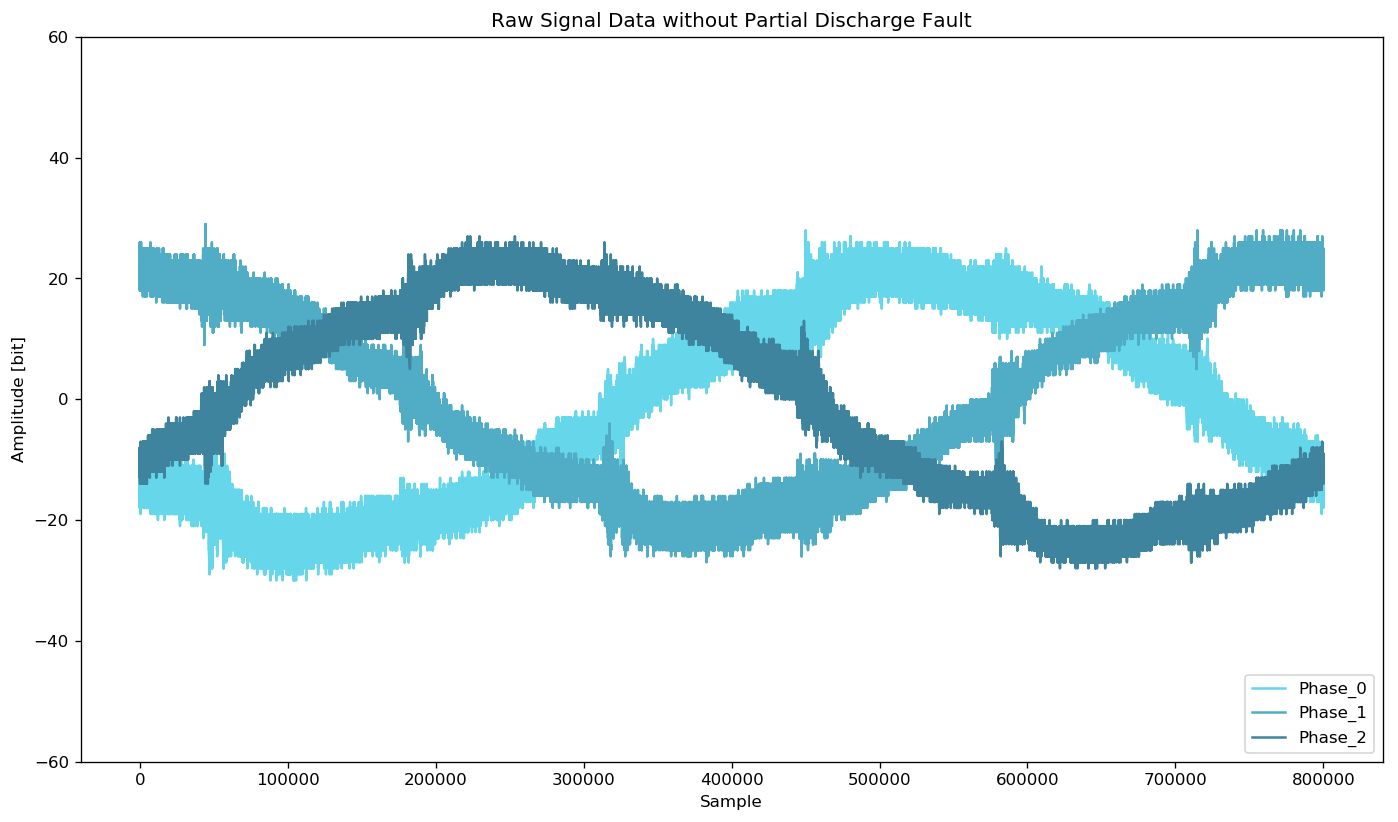

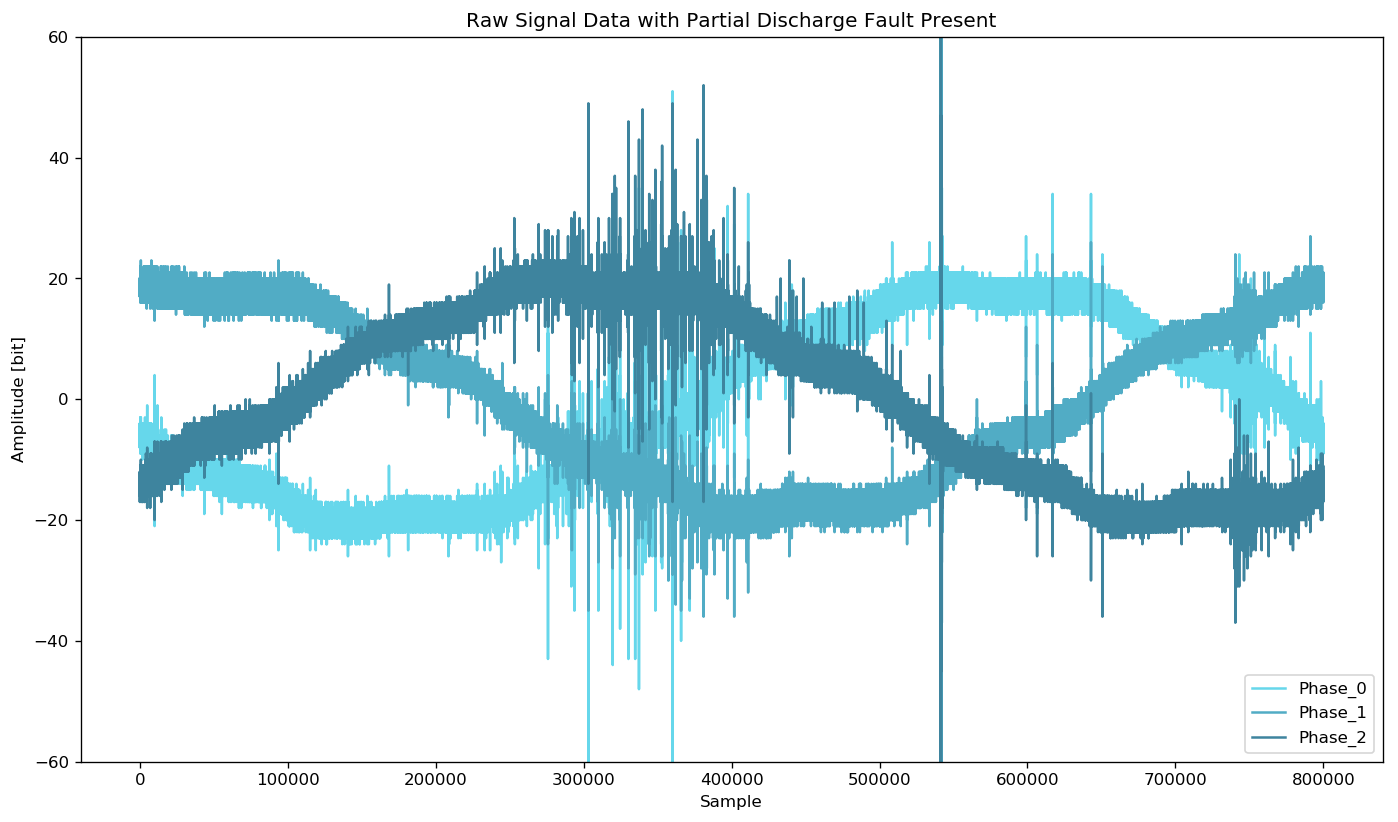

In [52]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(subset_train))), subset_train["936"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(subset_train))), subset_train["937"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(subset_train))), subset_train["938"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data without Partial Discharge Fault')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
plot_labels = ['Phase_0', 'Phase_1', 'Phase_2']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plt.plot(list(range(len(subset_train))), subset_train["939"], '-', label=plot_labels[0], color=blues[0])
plt.plot(list(range(len(subset_train))), subset_train["940"], '-', label=plot_labels[1], color=blues[1])
plt.plot(list(range(len(subset_train))), subset_train["941"], '-', label=plot_labels[2], color=blues[2])
plt.ylim((-60, 60))
plt.legend(loc='lower right')
plt.title('Raw Signal Data with Partial Discharge Fault Present')
plt.xlabel('Sample')
plt.ylabel('Amplitude [bit]')

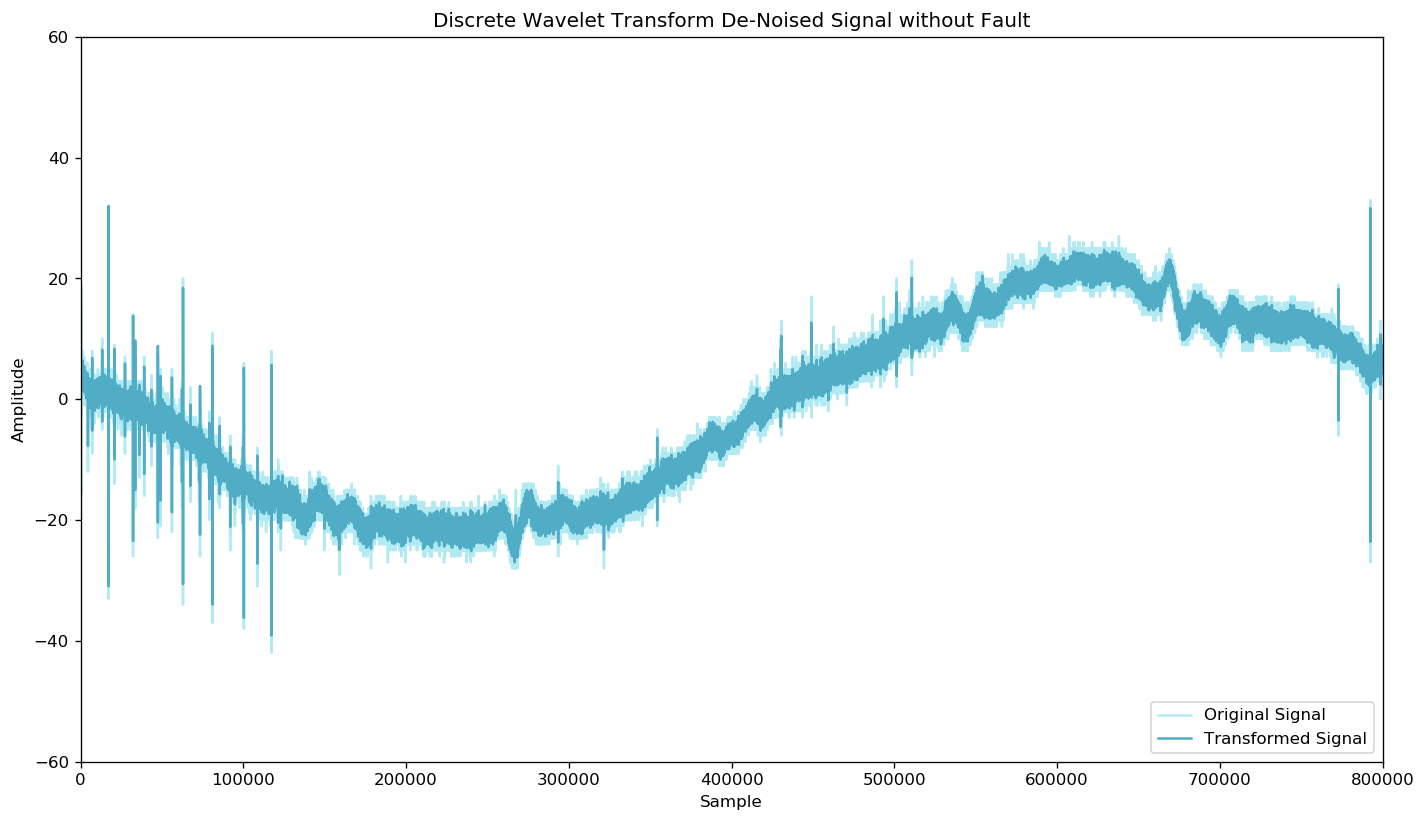

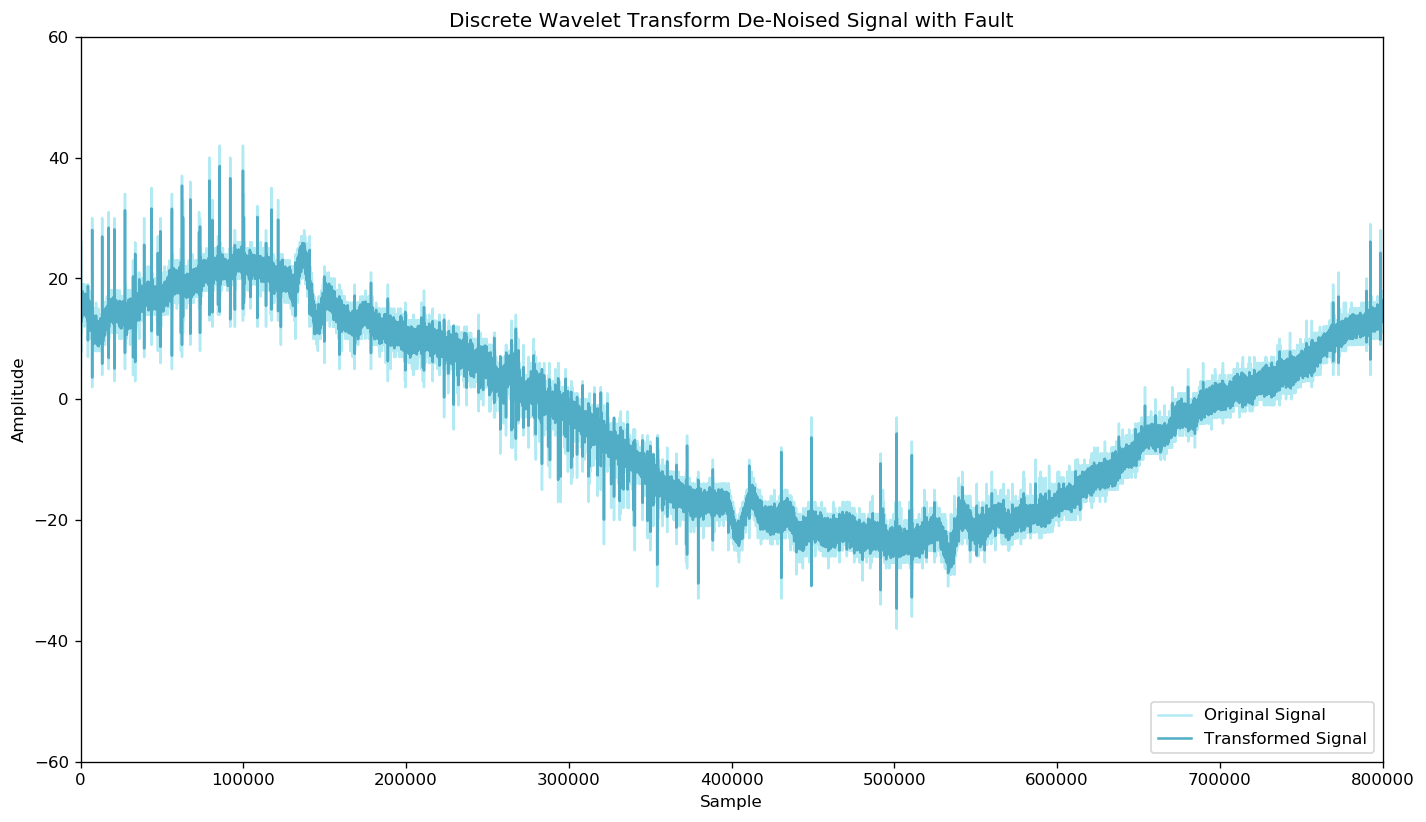

In [100]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def waveletSmooth( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    plt.plot( x, color="#66D7EB", alpha=0.5, label="Original Signal")
    plt.plot( y, color="#51ACC5", label="Transformed Signal" )
    plt.ylim((-60, 60))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(y)))
    return y
title0 = 'Discrete Wavelet Transform De-Noised Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised Signal with Fault'
signal_0 =  waveletSmooth(subset_train["33"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveletSmooth(subset_train["34"], wavelet="db4", level=1, title=title1 )

In [101]:
import pywt
from statsmodels.robust import mad
from scipy import signal
 
def waveletSmoothDetrend( x, wavelet="db4", level=1, title=None ):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # calculate a threshold
    sigma = mad( coeff[-level] )
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    #f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    #plt.plot( x.diff(), color="#66D7EB", alpha=0.5, label="De-Trended, Original Signal")
    #plt.plot( np.diff(y, n=1), color="#51ACC5", label="De-Trended, Transformed Signal" )
    #plt.ylim((-60, 60))
    #plt.xlabel('Sample')
    #plt.ylabel('Amplitude')
    #plt.legend(loc='lower right')
    #if title:
    #    ax.set_title(title)
    #ax.set_xlim((0,len(y)))
    return np.diff(y, n=1)


title0 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal with Fault'
signal_0 =  waveletSmoothDetrend(subset_train["33"], wavelet="db4", level=1, title=title0 )
signal_1 =  waveletSmoothDetrend(subset_train["34"], wavelet="db4", level=1, title=title1 )

32
283


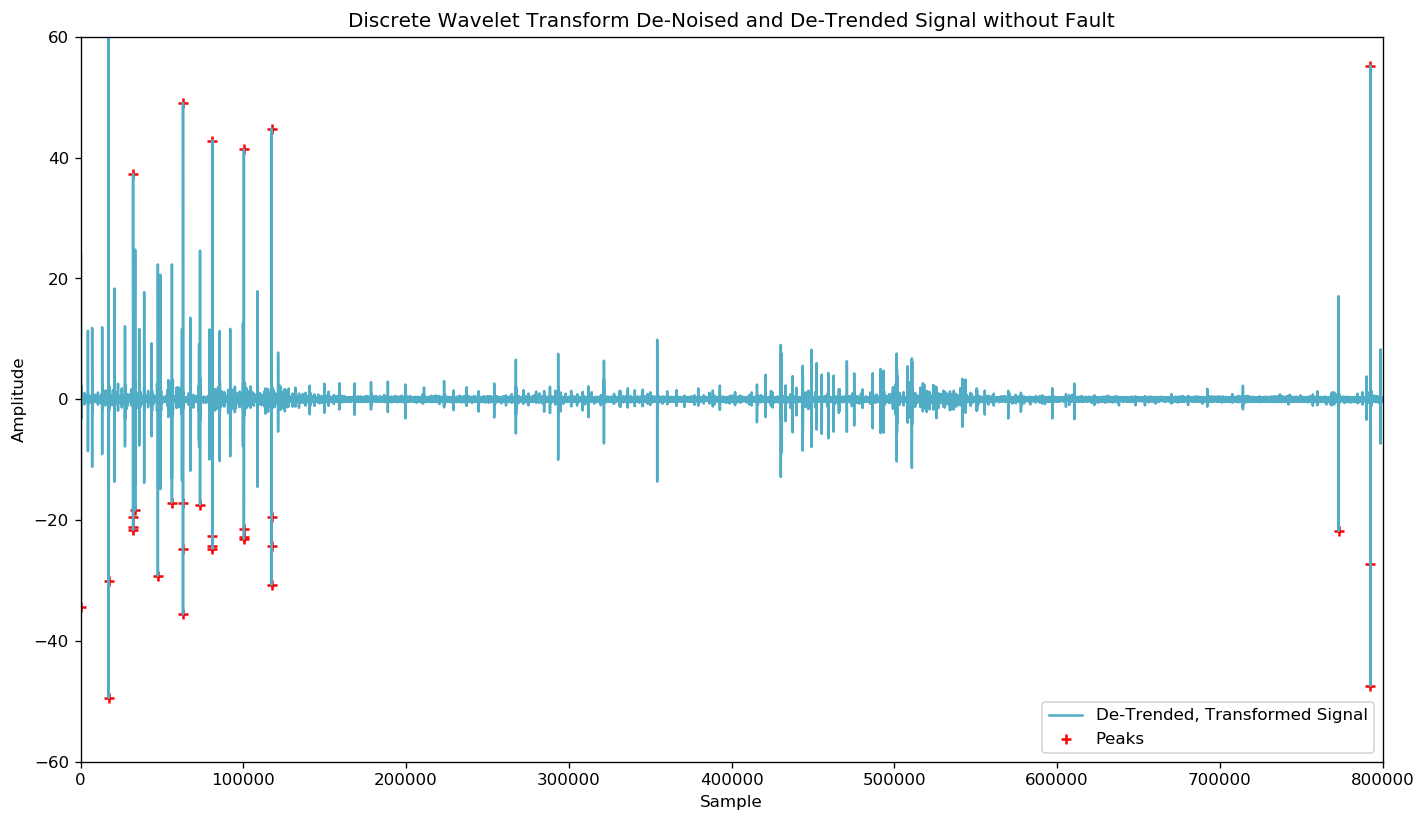

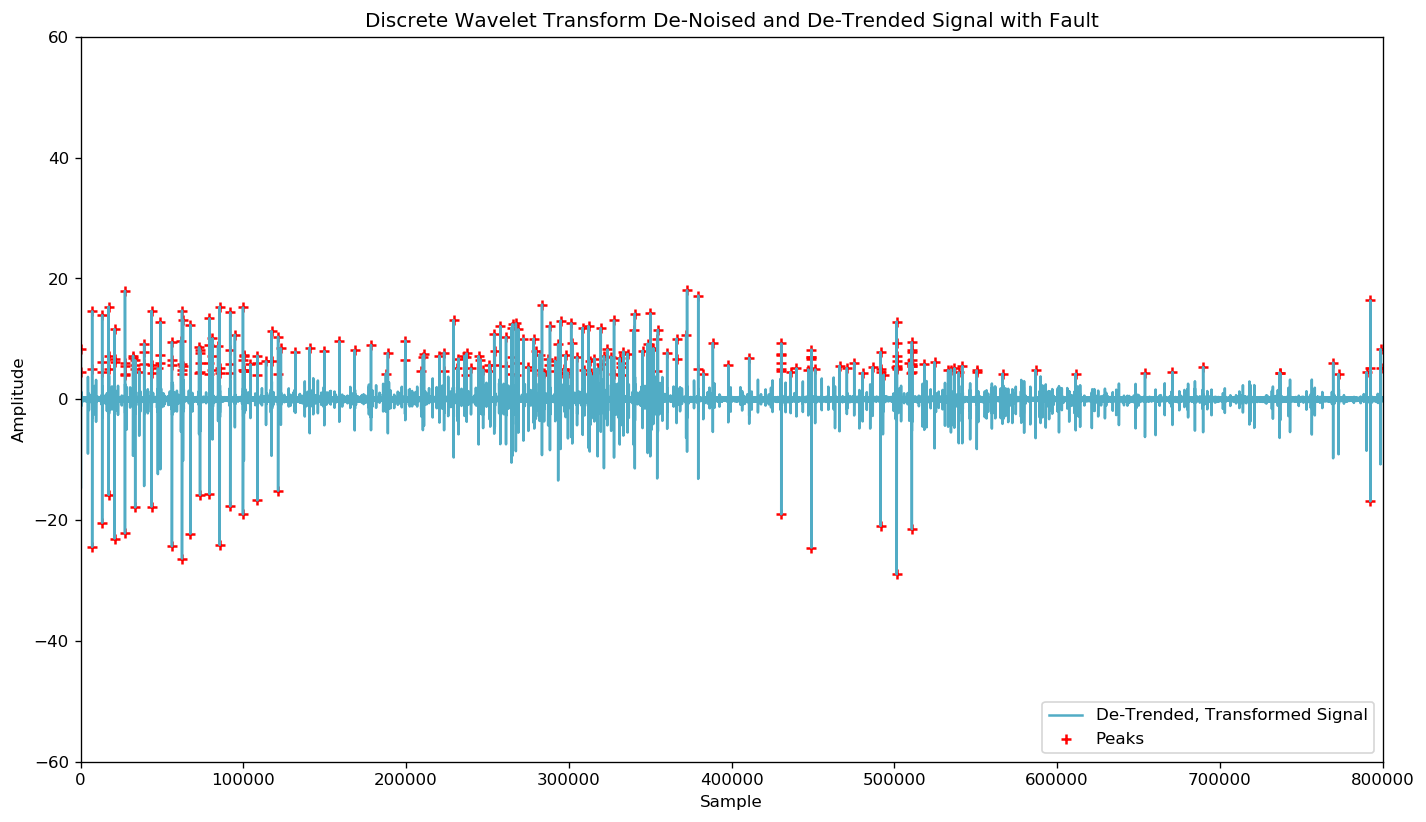

In [107]:
import peakutils

def find_peaks(signal, title):
    thresh = 0.7
    min_d = 1
    peaks = peakutils.indexes(1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    valleys = peakutils.indexes(-1.0*(signal), thres=thresh, min_dist=min_d)  # where peaks are
    peak_indexes = np.sort(np.concatenate((peaks, valleys)))

    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
    #plt.plot( x.diff(), color="#66D7EB", alpha=0.5, label="De-Trended, Original Signal")
    plt.plot( signal, color="#51ACC5", label="De-Trended, Transformed Signal" )
    plt.scatter(peak_indexes, signal[peak_indexes], marker="+", color="red", label="Peaks" )
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((320700, 320800))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(signal)))
    print(len(peak_indexes))
    return peak_indexes

title0 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal without Fault'
title1 = 'Discrete Wavelet Transform De-Noised and De-Trended Signal with Fault'
peak_indexes0 = find_peaks(signal_0, title=title0 )
peak_indexes1 = find_peaks(signal_1, title=title1 )

In [108]:
def cancel_false_peaks(signal, peak_indexes):
    false_peak_indexes = []
    max_sym_distance = 10  #
    max_pulse_train = 500  # 
    max_height_ratio = 0.25  # 
    for pk in range(len(peak_indexes)-1):
        if not peak_indexes[pk] in false_peak_indexes:
            if (signal[peak_indexes[pk]] > 0 and signal[peak_indexes[pk+1]] < 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])

            if (signal[peak_indexes[pk]] < 0 and signal[peak_indexes[pk+1]] > 0) and (peak_indexes[pk+1] - peak_indexes[pk]) < max_sym_distance:
                if min(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]]))/max(abs(signal[peak_indexes[pk]]),abs(signal[peak_indexes[pk+1]])) > max_height_ratio:
                    scrub = list(x for x in range(len(peak_indexes)) if peak_indexes[pk] <= peak_indexes[x] <= peak_indexes[pk]+max_pulse_train)
                    for x in scrub:
                        false_peak_indexes.append(peak_indexes[x])
    return false_peak_indexes

false_peak_indexes0 = cancel_false_peaks(signal_0, peak_indexes0)
false_peak_indexes1 = cancel_false_peaks(signal_1, peak_indexes1)

In [109]:
def cancel_high_amp_peaks(signal, peak_indexes, false_peak_indexes):
    peaks = peakutils.indexes(1.0*(signal), thres=0.80, min_dist=0)
    valleys = peakutils.indexes(-1.0*(signal), thres=0.80, min_dist=0) 
    hi_amp_pk_indexes = np.sort(np.concatenate((peaks, valleys)))
    for pk_idx in hi_amp_pk_indexes:
        if not pk_idx in false_peak_indexes:
            false_peak_indexes.append(pk_idx)
    return false_peak_indexes

false_peak_indexes0 = cancel_high_amp_peaks(signal_0, peak_indexes0, false_peak_indexes0)
false_peak_indexes1 = cancel_high_amp_peaks(signal_1, peak_indexes1, false_peak_indexes1)

In [110]:
# Calcel Peaks Flagged as False, Find True Preaks
def cancel_flagged_peaks(peak_indexes, false_peak_indexes):
    true_peak_indexes = list(set(peak_indexes) - set(false_peak_indexes))
    true_peak_indexes.sort()
    return true_peak_indexes

true_peak_indexes0 = cancel_flagged_peaks(peak_indexes0, false_peak_indexes0)
true_peak_indexes1 = cancel_flagged_peaks(peak_indexes1, false_peak_indexes1)

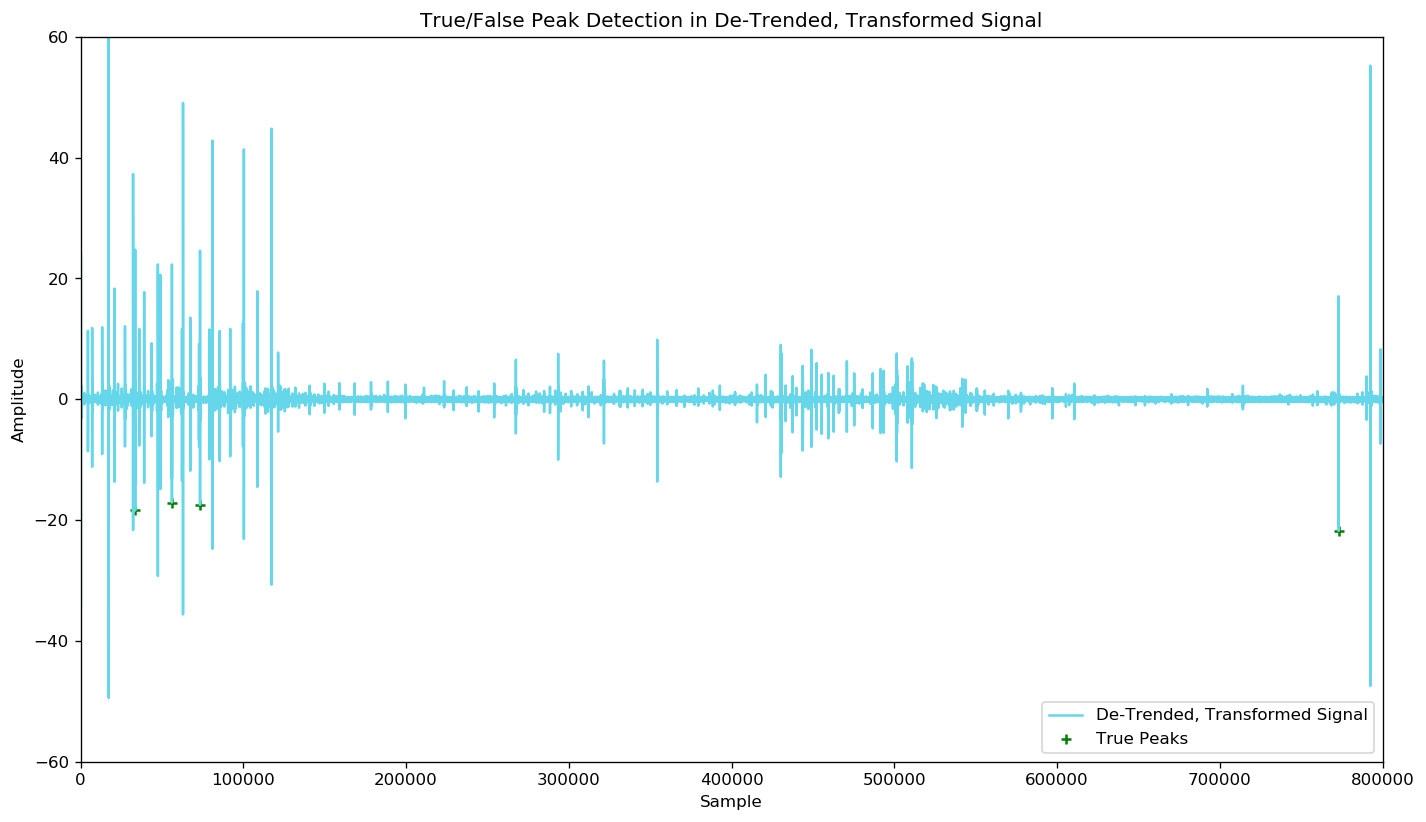

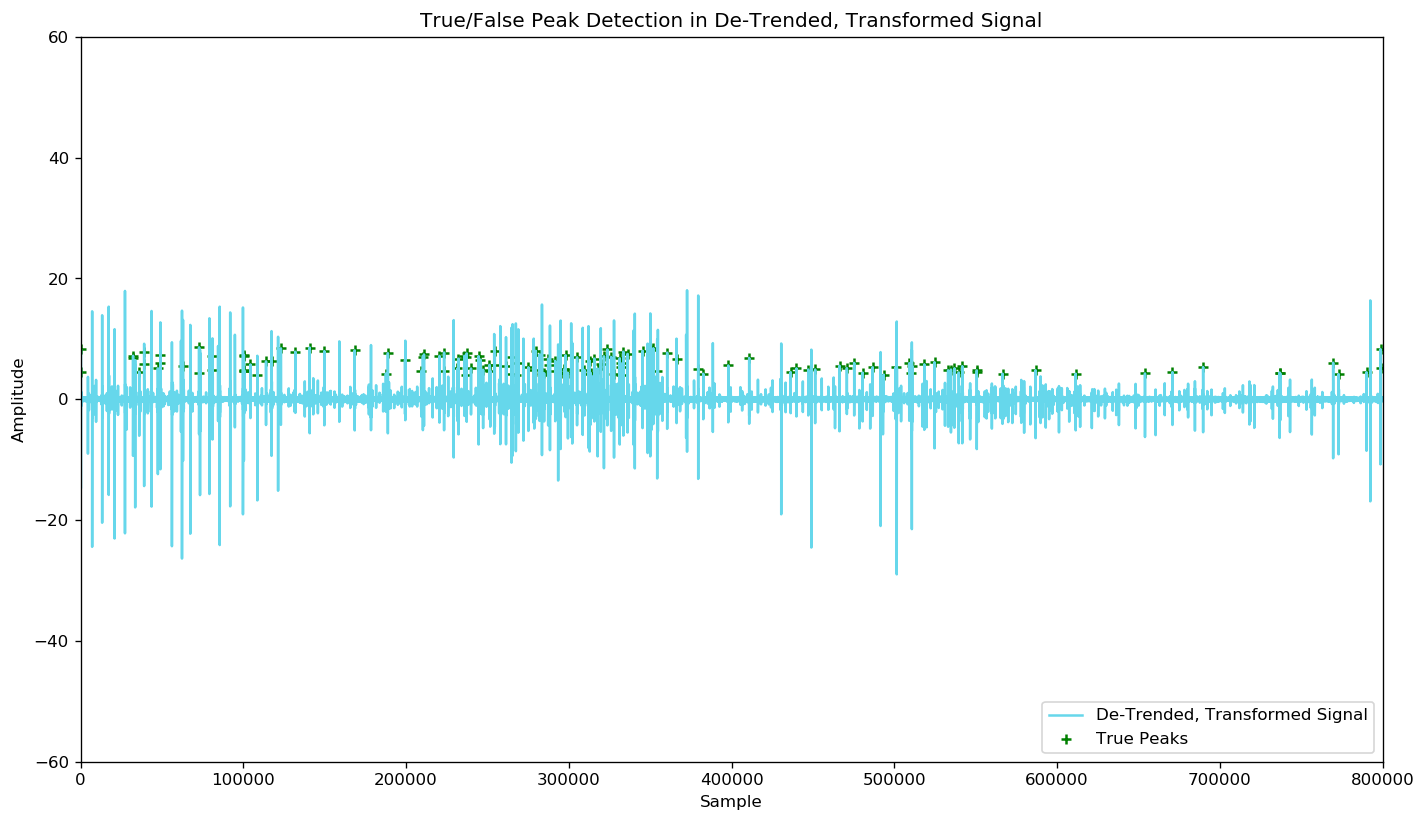

In [111]:
def plot_peaks(signal, true_peak_indexes, false_peak_indexes):
    f, ax = plt.subplots(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
    plt.plot( signal, color="#66D7EB", label="De-Trended, Transformed Signal" )  #5 alt color 1ACC5
    plt.scatter(true_peak_indexes, signal[true_peak_indexes], marker="+", color="green", label="True Peaks")
    #plt.scatter(false_peak_indexes, signal[false_peak_indexes], marker="x", color="red", label="False Peaks")
    plt.ylim((-25, 20))
    plt.ylim((-60, 60))
    plt.xlim((320700, 320800))
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='lower right')
    title = "True/False Peak Detection in De-Trended, Transformed Signal"
    if title:
        ax.set_title(title)
    ax.set_xlim((0,len(signal)))
    plt.show()
    return

plot_peaks(signal_0, true_peak_indexes0, false_peak_indexes0)
plot_peaks(signal_1, true_peak_indexes1, false_peak_indexes1)
    

In [97]:
import scipy
from statsmodels.robust import mad
import collections

#Feature Extraction Functions
def calculate_entropy(signal):
    counter_values = collections.Counter(signal).most_common()
    probabilities = [elem[1]/len(signal) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(signal):
    n5 = np.nanpercentile(signal, 5)
    n25 = np.nanpercentile(signal, 25)
    n75 = np.nanpercentile(signal, 75)
    n95 = np.nanpercentile(signal, 95)
    median = np.nanpercentile(signal, 50)
    mean = np.nanmean(signal)
    std = np.nanstd(signal)
    var = np.nanvar(signal)
    rms = np.nanmean(np.sqrt(signal**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]
 
def calculate_crossings(signal):
    zero_crossing_indices = np.nonzero(np.diff(np.array(signal) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(signal) > np.nanmean(signal)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]  # TODO no_mean_crossings a very promising feature!!!!

def calculate_peak_widths(peak_idxs):
    tmp_w = 1
    widths = []
    for idx in range(1,len(peak_idxs)):
        if peak_idxs[idx]-peak_idxs[idx-1] < 3:
            tmp_w +=1
        else:
            widths.append(tmp_w)
            tmp_w = 1
    widths.append(tmp_w)
    min_width = min(np.array(widths))
    max_width = max(np.array(widths))
    mean_width = np.nanmean(np.array(widths))
    num_true_peaks = len(widths)
    return min_width, max_width, mean_width, num_true_peaks

def calculate_peaks(signal, true_peak_indexes):
    # Peak Characteristics on True Peaks
    peak_values = signal[true_peak_indexes]
    num_detect_peak = len(true_peak_indexes)
    if num_detect_peak > 0:
        min_height = min(peak_values)
        max_height = max(peak_values)
        mean_height = np.nanmean(peak_values)
        min_width, max_width, mean_width, num_true_peaks = calculate_peak_widths(true_peak_indexes)
        return [min_height, max_height, mean_height, min_width, max_width, mean_width, num_detect_peak, num_true_peaks]
    else:
        return [0, 0, 0, 0, 0, 0, 0, 0]


def get_features(signal, true_peaks, false_peaks):
    entropy = calculate_entropy(signal)
    crossings = calculate_crossings(signal)
    statistics = calculate_statistics(signal)
    peaks = calculate_peaks(signal, true_peaks)
    return [entropy] + crossings + statistics + peaks

f0 = get_features(x0, true_peak_indexes0, false_peak_indexes0)
f3 = get_features(x3, true_peak_indexes3, false_peak_indexes3)

In [98]:
feature_columns = ["entropy", "n5", "n25", "n75", "n95", "median", "mean", "std", "var", "rms", "no_zero_crossings", "no_mean_crossings", "min_height", "max_height", "mean_height", "min_width", "max_width", "mean_width", "num_detect_peak", "num_true_peaks"]
print(feature_columns)
np.array(f0) - np.array(f3)

['entropy', 'n5', 'n25', 'n75', 'n95', 'median', 'mean', 'std', 'var', 'rms', 'no_zero_crossings', 'no_mean_crossings', 'min_height', 'max_height', 'mean_height', 'min_width', 'max_width', 'mean_width', 'num_detect_peak', 'num_true_peaks']


array([-3.46574024e-06, -8.31100000e+04, -8.31080000e+04,  5.20890666e-02,
        4.41929892e-03, -4.38864412e-03, -5.31562609e-02, -9.09432008e-06,
       -6.85979908e-08, -6.48429876e-03, -2.43853756e-03, -2.27281886e-02,
        2.04656799e+00,  6.37835811e+00,  4.05644272e+00,  0.00000000e+00,
       -1.00000000e+00,  1.45597484e-01, -2.75000000e+02, -2.38000000e+02])

In [2]:
import pandas as pd
df = pd.read_csv("/home/jeffrey/repos/VSB_Power_Line_Fault_Detection/extracted_features/train_features_thresh_0.63_db4.csv")
df.head()

,Unnamed: 0,signal_id,entropy,n5,n25,n75,n95,median,mean,std,...,no_mean_crossings,min_height,max_height,mean_height,min_width,max_width,mean_width,num_detect_peak,num_true_peaks,fault
0,0,0,13.592362,1704,1704,-0.000260,-0.000114,0.000107,0.000263,-9.189110e-06,...,0.003441,4.925916,19.306109,8.891536,1,2,1.270833,61,48,0
1,1,1,13.592364,1372,1372,-0.000253,-0.000114,0.000113,0.000258,-7.619841e-06,...,0.000934,3.138987,6.478299,4.209382,1,1,1.000000,8,8,0
2,2,2,13.592364,2790,2790,-0.000318,-0.000131,0.000133,0.000322,-8.093555e-06,...,0.003356,-13.128665,11.882134,-2.214358,1,1,1.000000,7,7,0
3,3,3,13.592366,83640,83640,-0.047150,-0.002776,0.002741,0.047790,-5.572517e-06,...,0.032311,-46.343804,50.533771,-5.588842,1,1,1.000000,9,9,1
4,4,4,13.592366,84814,84812,-0.052349,-0.004533,0.004496,0.053419,-9.478991e-08,...,0.026169,2.258549,13.746561,5.120080,1,3,1.092308,142,130,1


In [4]:
from sklearn.model_selection import train_test_split
features = ["entropy", "n5", "n25", "n75", "n95", "median", "mean", "std", "var", "rms", "no_zero_crossings", "no_mean_crossings", "min_height", "max_height", "mean_height", "min_width", "max_width", "mean_width", "num_detect_peak", "num_true_peaks"]
target = ["fault"]
x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], train_size=0.80, test_size=0.20, random_state=20)

In [5]:
import seaborn as sns
features = df[["entropy", "mean", "std", "var", "rms", "no_zero_crossings", "no_mean_crossings", "min_height", "max_height", "mean_height", "min_width", "max_width", "mean_width", "num_detect_peak", "num_true_peaks", "fault"]]
sns.pairplot(features, diag_kind="kde", kind="reg", hue="fault", palette="husl", height=3)

/home/jeffrey/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/jeffrey/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/jeffrey/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/jeffrey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwa

NameError: name 'plt' is not defined

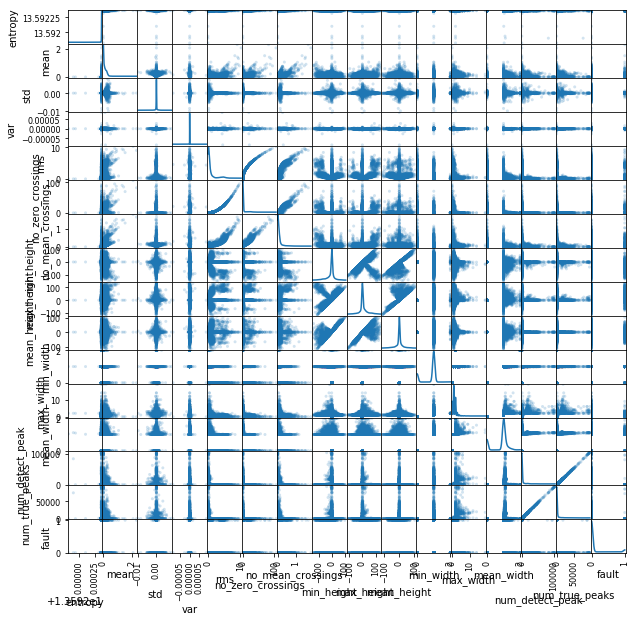

In [8]:
from matplotlib import pyplot as plt
pd.plotting.scatter_matrix(features, alpha=0.2, figsize=(10, 10), diagonal='kde')